In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
import json

### OWN FUNCTIONS 
from model_functions import *

## Main Model: Voting Classifier

In [13]:
aapl_with_features = pd.read_csv('../data/all_data/all_AAPL_data.csv')
googl_with_features = pd.read_csv('../data/all_data/all_GOOGL_data.csv')
msft_with_features = pd.read_csv('../data/all_data/all_MSFT_data.csv')

In [14]:
tickers = ['AAPL', 'GOOGL', 'MSFT']
data_dict = {
    'AAPL': aapl_with_features,
    'GOOGL': googl_with_features,
    'MSFT': msft_with_features
}
color_dict = {
     'AAPL': 'grey',
    'GOOGL': 'yellow',
    'MSFT': 'green'
}

statistics = ['accuracy', 'precision', 'recall', 'roc_auc']
#statistics = ['accuracy']

In [15]:
def get_tbm_target(df, ticker, horizon=5, pt_sl=[1,1]):
    df = df.copy()
    close = df[f'Close_{ticker}']
    
    log_ret = np.log(close / close.shift(1))
    volatility = log_ret.rolling(window=20).std()
    
    targets = pd.Series(index=df.index, dtype=float)
    
    for i in range(len(df) - horizon):
        price_start = close.iloc[i]
        current_vol = volatility.iloc[i] ### dynamic barrier for each day
        
        upper_barrier = price_start * (1 + current_vol * pt_sl[0])
        lower_barrier = price_start * (1 - current_vol * pt_sl[1])
        
        future_prices = close.iloc[i+1 : i+ 1 + horizon]
        
        targets.iloc[i] = 0
        
        for price_future in future_prices:
            if price_future >= upper_barrier:
                targets.iloc[i] = 1 # profit taking hit
                break
            elif price_future <= lower_barrier:
                targets.iloc[i] = -1 # stop loss hit
                break
    df['Target'] = targets
    return df.dropna(subset=['Target'])

In [16]:
print(msft_with_features.columns[:47])
def get_target(input_df, ticker):
    df = input_df.copy()
    df['Target'] = (df[f'Close_{ticker}'].shift(-1) > df[f'Close_{ticker}']).astype(int)
    df.dropna(inplace=True)
    return df

Index(['index', 'DATE', 'Close_MSFT', 'High_MSFT', 'Low_MSFT', 'Open_MSFT',
       'Volume_MSFT', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9', 'ATRr_14', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0',
       'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'Target',
       'FEDFUNDS', 'DGS10', 'CPI', 'Dollar_idx', 'USEPUINDXD', 'Close_VIX',
       'High_VIX', 'Low_VIX', 'Open_VIX', 'VIX_percent', 'Is_Panic', 'Is_Calm',
       'Is_Uncertain', 'Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL',
       'Volume_AAPL', 'Close_GOOGL', 'High_GOOGL', 'Low_GOOGL', 'Open_GOOGL',
       'Volume_GOOGL', 'log_return', 'cusum', 'cusum_pos', 'cusum_neg',
       'anomaly_raw', 'is_anomaly'],
      dtype='object')


### SEARCHING FOR BEST FEATURES BY USING RFECV

In [17]:
def best_features(data_dict, tickers, statistics):
    warnings.filterwarnings('ignore')
    feature_dict = {}

    for i, share in enumerate(tickers):
        feature_dict[share] = {}
        df = get_tbm_target(data_dict[share], share)
        features = [col for col in df.columns if col not in ['Target', 'index', 'DATE']]

        to_remove = [f'Volume_{share}_lag1', f'Volume_{share}_lag2', f'Volume_{share}_lag3', f'Volume_{share}_lag5',
                         f'RSI_14_lag1', 'RSI_14_lag2', 'RSI_14_lag3', 'RSI_14_lag5', 'log_return_lag1', 'log_return_lag2',
                         'log_return_lag3', 'log_return_lag5']

        '''if share == 'AAPL':
            additional_to_remove = ['rolling_max_20', 'rolling_max_20', 'dist_to_max_20', 'dist_to_min_20', 'rolling_max_60', 'rolling_max_60', 'dist_to_max_60', 'dist_to_min_60']
            to_remove += additional_to_remove
            '''

        features = [f for f in features if f not in to_remove]

        X = df[features]
        y = df['Target']

        model_judge_rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42, n_jobs=-1)

        # Second model to check
        model_judge_xgb = XGBClassifier(
            n_estimators=50,
            max_depth=4,
            learning_rate=0.1,
            n_jobs=-1,
            random_state=42,
            eval_metric='logloss',
            use_label_encoder=False
        )

        ### test on different models for best acc for each company
        '''if share != 'MSFT':
            model_judge = model_judge_rf
        else:
            model_judge = model_judge_xgb
            '''

        model_judge = model_judge_rf

        for stat in statistics:
            cv_split = TimeSeriesSplit(n_splits=5)

            min_feats = 10 if share == 'AAPL' else 7
            rfecv = RFECV(
                estimator=model_judge,
                min_features_to_select=min_feats,
                step=1,
                cv=cv_split,
                scoring=stat,
                n_jobs=-1)

            rfecv.fit(X, y)

            print(f"Optimal features numer by RFECV : {rfecv.n_features_}")
            selected_features = [f for f, s in zip(features, rfecv.support_) if s]

            if share == 'AAPL' or share == 'MSFT':
                X_refined = X[selected_features]
                desired_features = 10
                rfe_final = RFE(
                    estimator=model_judge,
                    n_features_to_select=desired_features,
                    step=1
                )

                rfe_final.fit(X_refined, y)
                final_aapl_features = [f for f, s in zip(selected_features, rfe_final.support_) if s]

                selected_features = final_aapl_features
            print(f"Winner features for {stat} ({len(selected_features)}):")
            print(selected_features)
            feature_dict[share][stat] = selected_features

    with open("../models_results/feature_dict.json", "w") as f:
        json.dump(feature_dict, f, indent=4)

    return feature_dict

In [18]:
bf = best_features(data_dict, tickers, statistics)
print(bf)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for 

Optimal features numer by RFECV : 11
Winner features for accuracy (10):
['MACDh_12_26_9', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'Dollar_idx', 'cusum', 'cusum_neg', 'dist_to_min_20', 'rolling_min_60', 'rolling_min_60_AAPL', 'dist_to_min_20_AAPL']


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [8]:
def model_train(tickers, statistics, feature_dict):
    result_dict = {}

    for i, share in enumerate(tickers):
        df = get_target(data_dict[share], share)
        features = [col for col in df.columns if col not in ['Target', 'index', 'DATE']]

        X = df[features]
        y = df['Target']
        result_dict[share] = {}

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

        for stat in statistics:
            selected_cols = feature_dict[share][stat]

            rf_pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(n_estimators=100, max_depth=3, min_samples_leaf=10, random_state=42, n_jobs=-1))
            ])

            svm_pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('svc', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)),
            ])

            xgb_pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(n_estimators=50, max_depth=4, learning_rate=0.1, eval_metric='logloss', random_state=42,
                               n_jobs=-1)),
            ])

            main_model = VotingClassifier(
                estimators=[('xgb', xgb_pipeline), ('svc', svm_pipeline), ('rf', rf_pipeline), ],
                voting='soft')

            main_model.fit(X_train[selected_cols], y_train)

            y_pred = main_model.predict(X_test[selected_cols])
            acc = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            print('*' * 40)
            print(f"Results for {share} for best stat: {stat}:")
            print("Accuracy:", acc)
            print("Precision:", precision)
            print("Recall:", recall)
            print("ROC AUC score:", roc_auc)
            result_dict[share][stat] = [acc, precision, recall, roc_auc]
    return result_dict


In [9]:
result_dict = model_train(tickers, statistics, feature_dict=bf)
print(result_dict)

****************************************
Results for AAPL for best stat: accuracy:
Accuracy: 0.4864091559370529
Precision: 0.5375
Recall: 0.3421750663129973
ROC AUC score: 0.4987272847092937
****************************************
Results for GOOGL for best stat: accuracy:
Accuracy: 0.45064377682403434
Precision: 0.5298507462686567
Recall: 0.18112244897959184
ROC AUC score: 0.4879553612976136
****************************************
Results for MSFT for best stat: accuracy:
Accuracy: 0.4563662374821173
Precision: 0.5
Recall: 0.005263157894736842
ROC AUC score: 0.4994967827091239
{'AAPL': {'accuracy': [0.4864091559370529, 0.5375, 0.3421750663129973, 0.4987272847092937]}, 'GOOGL': {'accuracy': [0.45064377682403434, 0.5298507462686567, 0.18112244897959184, 0.4879553612976136]}, 'MSFT': {'accuracy': [0.4563662374821173, 0.5, 0.005263157894736842, 0.4994967827091239]}}


In [10]:
result_by_stats = {}
for stat in statistics:
    result_by_stats[stat] = {}
    for share in tickers:
        result_by_stats[stat][share] = result_dict[share][stat]
    df_to_save = pd.DataFrame.from_dict(
        result_by_stats[stat], 
        orient='index',
        columns=['accuracy', 'precision', 'recall', 'roc_auc'])
    print('*'*10, f'Results for {stat}', '*'*10)
    print(df_to_save)
    df_to_save.to_csv(f'../models_results/main_model_results_by_{stat}.csv')

********** Results for accuracy **********
       accuracy  precision    recall   roc_auc
AAPL   0.486409   0.537500  0.342175  0.498727
GOOGL  0.450644   0.529851  0.181122  0.487955
MSFT   0.456366   0.500000  0.005263  0.499497


********** accuracy **********
   Ticker  accuracy  precision    recall   roc_auc                Model
0    AAPL  0.532274   0.572728  0.507338  0.507338        Random Forest
1    AAPL  0.531281   0.530021  0.966038  0.507128                  SVM
2    AAPL  0.528302   0.534913  0.807910  0.506390  Logistic Regression
3    AAPL  0.527110   0.527110  1.000000  0.500000          Always rise
4    AAPL  0.522927   0.541005  0.630763  0.516648         Based on SMA
5    AAPL  0.499404   0.525245  0.525245  0.497917   Based on yesterday
6    AAPL  0.486594   0.494415  0.494969  0.494969              XGBoost
7    AAPL  0.486409   0.537500  0.342175  0.498727      Ensemble (Main)
8   GOOGL  0.523337   0.523337  1.000000  0.500000          Always rise
9   GOOGL  0.508441   0.522956  0.871269  0.483405                  SVM
10  GOOGL  0.501396   0.520700  0.589558  0.497120         Based on SMA
11  GOOGL  0.500795   0.522960  0.523159  0.499704   Based on yesterday
12  GOOGL  0.496524   0.487057  0

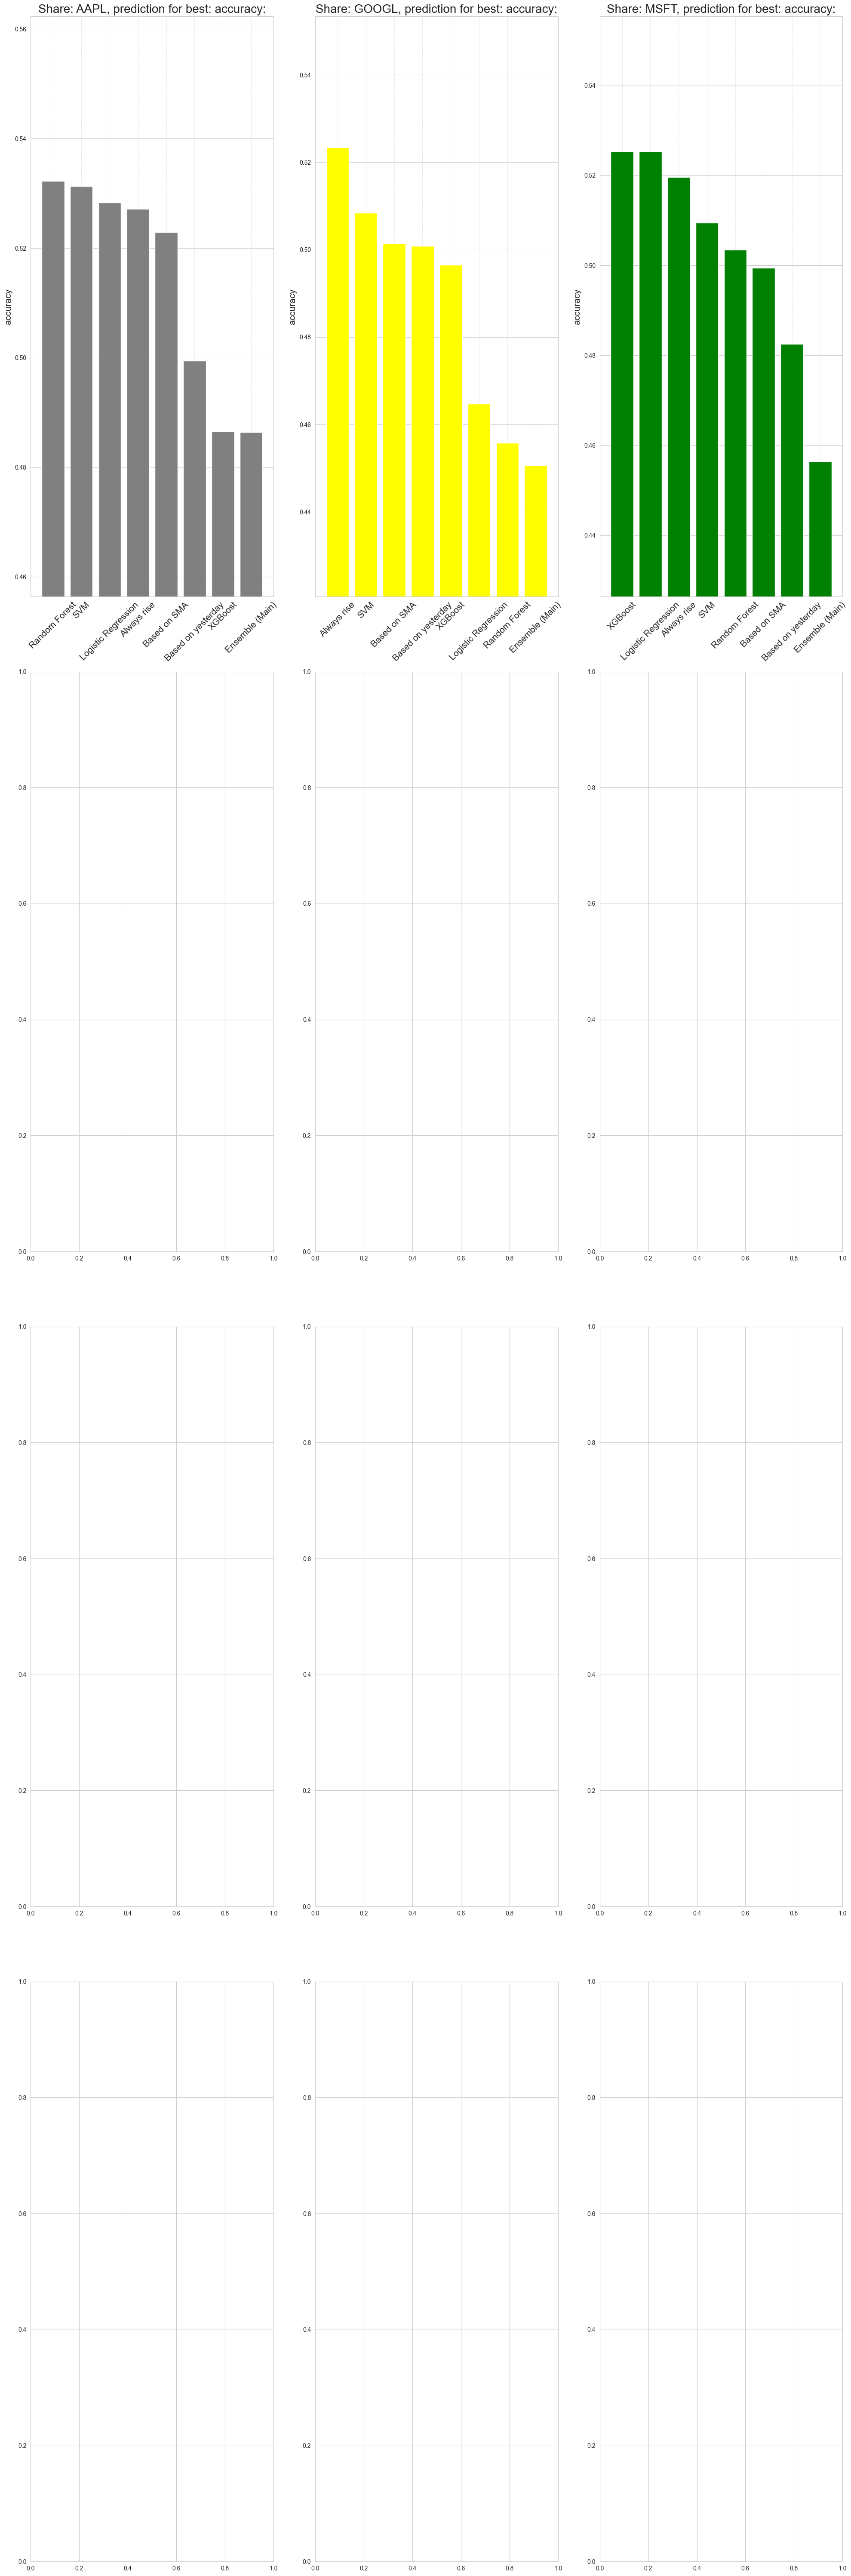

In [11]:
rf_results = pd.read_csv('../models_results/RF_results.csv')
svm_results = pd.read_csv('../models_results/SVM_results.csv')
xgb_results = pd.read_csv('../models_results/XGB_results.csv')
lr_results = pd.read_csv('../models_results/LR_results.csv')
bs1_results = pd.read_csv('../models_results/bs1_results.csv')
bs2_results = pd.read_csv('../models_results/bs2_results.csv')
bs3_results = pd.read_csv('../models_results/bs3_results.csv')
main_model_acc = pd.read_csv('../models_results/main_model_results_by_accuracy.csv')
main_model_precision = pd.read_csv('../models_results/main_model_results_by_precision.csv')
main_model_recall = pd.read_csv('../models_results/main_model_results_by_recall.csv')
main_model_roc_auc = pd.read_csv('../models_results/main_model_results_by_roc_auc.csv')

bs1_results['Model'] = 'Based on yesterday'
bs2_results['Model'] = 'Always rise'
bs3_results['Model'] = 'Based on SMA'
rf_results['Model'] = 'Random Forest'
svm_results['Model'] = 'SVM'
xgb_results['Model'] = 'XGBoost'
lr_results['Model'] = 'Logistic Regression'
main_model_acc['Model'] = 'Ensemble (Main)'
main_model_precision['Model'] = 'Ensemble (Main)'
main_model_recall['Model'] = 'Ensemble (Main)'
main_model_roc_auc['Model'] = 'Ensemble (Main)'

all_dfs_acc = [bs1_results, bs2_results, bs3_results, rf_results, svm_results, xgb_results, lr_results, main_model_acc]
all_dfs_precision = [bs1_results, bs2_results, bs3_results, rf_results, svm_results, xgb_results, lr_results, main_model_precision]
all_dfs_recall = [bs1_results, bs2_results, bs3_results, rf_results, svm_results, xgb_results, lr_results, main_model_recall]
all_dfs_roc_auc = [bs1_results, bs2_results, bs3_results, rf_results, svm_results, xgb_results, lr_results, main_model_roc_auc]

all_dfs = [all_dfs_acc, all_dfs_precision, all_dfs_recall, all_dfs_roc_auc]

fig, axes = plt.subplots(4, 3, figsize=(20, 60))

for num, stat in enumerate(statistics):

    combined_df = pd.concat(all_dfs[num])
    
    if 'Unnamed: 0' in combined_df.columns:
        combined_df = combined_df.rename(columns={'Unnamed: 0': 'Ticker'})
    
    combined_df = combined_df.sort_values(by=['Ticker', stat], ascending=[True, False])
    
    combined_df = combined_df.reset_index(drop=True)
    
    print('*' * 10, stat, '*' * 10)
    print(combined_df)
    
    for i, t in enumerate(combined_df['Ticker'].unique()):
        subsets = combined_df[combined_df['Ticker'] == t]
        subsets = subsets.sort_values(by=stat, ascending=False)
        
        y_min = subsets[stat].min() - 0.03
        y_max = subsets[stat].max() + 0.03
        
        axes[num][i].bar(subsets['Model'], subsets[stat], color=color_dict[t])
        axes[num][i].set_title(f'Share: {t}, prediction for best: {stat}:', size=20)
        axes[num][i].set_ylim(y_min, ymax=y_max)
        axes[num][i].grid(axis='x', alpha=0.5, linestyle='--')
        axes[num][i].set_ylabel(stat, fontsize=15)
        axes[num][i].tick_params(axis='x', labelsize=15, labelrotation=45)
plt.tight_layout()
plt.show()



